In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [4]:
cache_states = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Run Task (with learning)

In [5]:
model.reset()
cache_acts = []
cache_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 10
Now I just cached at location: 20
Now I just cached at location: 30
Now I just cached at location: 40
Now I just cached at location: 50
Now I just cached at location: 60
Now I just cached at location: 70
Now I just cached at location: 80


In [6]:
_, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)

In [7]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

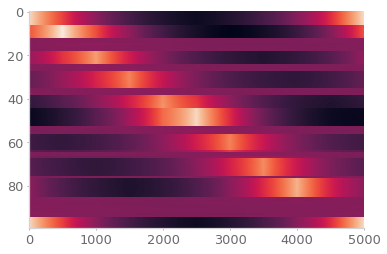

In [8]:
plt.figure()
plt.imshow(output, aspect='auto')
plt.show()

# Define cache activity as a mean over some time window

In [9]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][steps+model.seed_steps-1, location, :]#.mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [10]:
cache_mean = avg_cache_acts.mean(axis=0)

In [11]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[steps-1, location, :]#.mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

In [12]:
def nb(mu, std_scaling=1.0, mu_scaling=0.75, shift=0.0):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8 + shift
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    nb_mu = nbinom.rvs(n, p)
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Fig 3ab, Fig 4: cache v. visit correlation

In [13]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
cache_retrieval_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        retrieval_act_j = avg_retrieval_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)
            c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
            cache_retrieval_corr['Distance'].append(_distance)
            cache_retrieval_corr['Correlation'].append(c_r_corr)


In [14]:
# cc

In [15]:
ccc = pd.DataFrame(cache_cache_corr)
ccc = ccc[ccc['Distance']==0]
print(ccc)

     Distance  Correlation
0           0     0.500378
1           0     0.477129
2           0     0.490327
27          0     0.512056
28          0     0.493927
29          0     0.501336
51          0     0.560128
52          0     0.481468
53          0     0.509818
72          0     0.580931
73          0     0.533310
74          0     0.532185
90          0     0.457424
91          0     0.461320
92          0     0.482552
105         0     0.488557
106         0     0.488684
107         0     0.440826
117         0     0.528763
118         0     0.523570
119         0     0.504143
126         0     0.444184
127         0     0.518392
128         0     0.535375
132         0     0.487770
133         0     0.571848
134         0     0.517019


In [16]:
np.mean(ccc)

Distance       0.000000
Correlation    0.504571
dtype: float64

In [17]:
# cr

In [18]:
crc = pd.DataFrame(cache_retrieval_corr)
crc = crc[crc['Distance']==0]
print(crc)

     Distance  Correlation
0           0     0.530871
1           0     0.571757
2           0     0.537715
27          0     0.579085
28          0     0.538385
29          0     0.541622
51          0     0.442270
52          0     0.518204
53          0     0.470335
72          0     0.497803
73          0     0.494556
74          0     0.480657
90          0     0.441166
91          0     0.419580
92          0     0.494276
105         0     0.546453
106         0     0.549224
107         0     0.537037
117         0     0.447878
118         0     0.496285
119         0     0.504968
126         0     0.510427
127         0     0.518796
128         0     0.448727
132         0     0.510206
133         0     0.571718
134         0     0.553540


In [19]:
np.mean(crc)

Distance       0.00000
Correlation    0.50939
dtype: float64

In [20]:
# vv

In [21]:
vvc = pd.DataFrame(visit_visit_corr)
vvc = vvc[vvc['Distance']==0]

In [22]:
np.mean(vvc)

Distance       0.000000
Correlation    0.224267
dtype: float64

# Plot

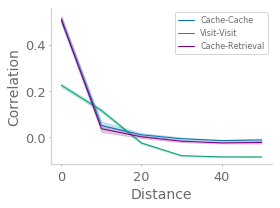

In [23]:
plt.figure(figsize=(4,3))
sns.lineplot(
    x='Distance', y='Correlation', data=pd.DataFrame(cache_cache_corr),
    color='C0', label='Cache-Cache')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(visit_visit_corr),
    color='C2', label='Visit-Visit')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(cache_retrieval_corr),
    color='purple', label='Cache-Retrieval')
plt.tight_layout()
plt.savefig('c_r_corr.png', dpi=300)
plt.show()